# Исследование результатов A/A/B-эксперимента

<h3> Бриф <a class="tocSkip"></h2>

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

<h3> Цель исследования <a class="tocSkip"></h2>

Изучить воронку продаж, узнать как пользователи доходят до покупки, анализ результатов A/A/B-эксперимента.

<h3> План работы <a class="tocSkip"></h2>

1. Обзор данных 
2. Предобработка данных
3. Анализ данных
4. Изучение воронки событий
5. Изучение результатов эксперимента
6. Общий вывод

### Обзор данных <a id='the_destination'></a>

In [ ]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import math as mth

In [ ]:
# чтение файла
logs = pd.read_csv('logs_exp.csv', sep='\t')

In [ ]:
logs.head()

In [ ]:
logs.info()

**Промежуточный вывод**

При осмотре данных были выявлены следующие моменты:
1. Названия столбцов начинаются с заглавной буквы
3. Столбец с датой не обладает соответствующим типом данных
4. Пропусков нет

####

### Предобработка данных

In [ ]:
# меняем названия столбцов
logs.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
print(logs.columns)

In [ ]:
# изменим тип данных в 'event_timestamp' и добавим новый столбец с датой
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['date'] = logs['event_timestamp'].dt.date
logs.head()

In [ ]:
# проверим наличие дубликатов
logs.duplicated().sum()

In [ ]:
# уберем дубликаты
logs.drop_duplicates()

**Промежуточный вывод**

В ходе предобработки данных были проведены следующие мероприятия:
1. Изменение названий столбцов
2. Изменение типов данных на требуемый
3. Очистка данных от дубликатов

####

### Анализ данных

In [ ]:
# количество событий в логе
print('Общее количество событий в логе:', logs.shape[0])

In [ ]:
# количество пользователей в логе
print('Количество уникальных пользователей в логе:', len(logs['user_id'].unique()))

In [ ]:
# среднее количество событий на пользователя
logs.groupby('user_id').agg({'event_name': 'count'}).describe()

В среднем на пользователя приходится 32 события. Только около 25% пользователей совершают более 37 действий с сайтом.

Посмотрим на распределние нормальных значений на графике

In [ ]:
# посмотрим на распределение нормальных значений количества событий на пользователя
fig, ax = plt.subplots(figsize = (17,2))
ax = logs.groupby('user_id').agg({'event_name': 'count'}).boxplot(vert = False, ax=ax)
ax.set_title('Диаграмма размаха')
ax.set_xlim(0, 100);

Медианное значение равно 20, т.е. 20 событий на пользователя. Нормальные значения колеблются в диапозоне от 10 до 40 событий.

In [ ]:
# изучим временной интервал теста
print('Дата начала проведения теста:', logs.date.min())
print('Дата окончания проведения теста:', logs.date.max())

In [ ]:
plt.figure(figsize=(18, 5))

sns.histplot(x=logs['event_timestamp'], data=logs, hue='exp_id', palette='Paired')
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Даты')
plt.ylabel('Количество посетителей');

Посмотрим подробнее на динамику событий тогда, когда данные только начали подтягиваться.

In [ ]:
plt.figure(figsize=(18, 5))

sns.histplot(x=logs['event_timestamp'].dt.strftime('%Y-%m-%d %H'),
             data=logs.query('event_timestamp >= "2019-07-31" and event_timestamp <= "2019-08-01"'),
             hue='exp_id', palette='Paired')
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Даты')
plt.ylabel('Количество посетителей')
plt.xticks(rotation=45);

Рассмотрев динамику количества совершаемых событий, можем увидеть резкий всплеск 2019-07-31 в 21 час. Видимо тест был запущен именно в это время.

На графике видно, что полными данными могут можно считать только те, что начинают поступать с 2019-07-31. 

Т.е. мы располагаем логами в период от 2019-07-31 до 2019-08-07.

In [ ]:
# отбросим старые данные
logs_new = logs.copy()
logs_new = logs_new.query('event_timestamp >= "2019-07-31"')

In [ ]:
# посмотрим, сколько данных отбросилась при фильтрации
print('Процент отфильтрованных записей', round((len(logs)/len(logs_new) - 1) * 100, 2))
print('Процент отброшенных пользователей', round(100 - logs_new['user_id'].nunique()/logs['user_id'].nunique() * 100, 2))

Фильтрация затронула менее 1% данных.

In [ ]:
# проверяем наличие пользователей каждой группы
logs_new.groupby('exp_id').agg({'user_id': 'nunique'})

И на графике и на отдельной проверке видно, что данные есть по всем экспериментальным группам.

####

### Изучение воронки событий

**Посмотрим, какие события есть в логах и как часто они встречаются**

In [ ]:
# формируем датафрейм с количеством логов и уникальными пользователями по событиям
event_freq = (
    logs_new.groupby('event_name').agg({'user_id': ['count', 'nunique']})
    .reset_index()
)
event_freq.columns = ['event_name', 'user_cnt', 'user_unq']
event_freq = event_freq.sort_values('user_cnt', ascending=False)
event_freq

Всего 5 основных событий:
* `MainScreenAppear` - появление основной страницы
* `OffersScreenAppear` - появление страницы с продуктами
* `CartScreenAppear` - заход на страницу корзины
* `PaymentScreenSuccessful` - пояление на экране окна после покупки
* `Tutorial` - обучалка

In [ ]:
plt.figure(figsize=(15,5))

ax = sns.barplot(data=event_freq, y='event_name', x='user_cnt', palette='Paired')

# добавление подписей значений к столбцам
for i, p in enumerate(ax.patches):
    ax.text(p.get_width() + 20, p.get_y() + p.get_height() / 2, 
            f'{int(event_freq.iloc[i]["user_cnt"])}', 
            ha='left', 
            fontsize=10)

    ax.set_title('Частота событий в логах')
ax.set_xlabel('Частота')
ax.set_ylabel('События');

* Чаще всего пользователи заходят на основную страницу `MainScreenAppear` (частота = 118681)
* Далее меньше юзеров открывают страницу с продуктами `OffersScreenAppear` (частота = 46724)
* `CartScreenAppear`, частота = 42623
* `PaymentScreenSuccessful`, частота = 34253
* На страницу `Tutorial`заходят реже всего (частота = 1048)

**Посмотрим сколько пользователей совершали каждое из этих событий**

In [ ]:
plt.figure(figsize=(13,5))

ax = sns.barplot(data=event_freq, y='event_name', x='user_unq', palette='Paired')

# добавление подписей значений к столбцам
for i, p in enumerate(ax.patches):
    ax.text(p.get_width() - 200, p.get_y() + p.get_height() / 2, 
            f'{int(event_freq.iloc[i]["user_unq"])}', 
            ha='right', 
            fontsize=14,
            color = 'white')

ax.set_title('Количество пользователей, совершивших событие')
ax.set_xlabel('Количество пользователей')
ax.set_ylabel('События');

Также как и в случае с частотой встречаемости событий в логе
* Cобытие `MainScreenAppear` совершили большинство пользователей, участвующих в тесте
* далее идут все также `OffersScreenAppear` (4606), `CartScreenAppear` (3742), `PaymentScreenSuccessful` (3542)
* `Tutorial` на последнем месте по количеству пользователей, это событие совершили 845 юзеров.

**Посчитем долю пользователей, которые хоть раз совершали событие**

In [ ]:
# поделим количество уникальных пользователей в событии на общее число уникальных пользователей
event_freq['one_time_users'] = round(event_freq['user_unq'] / len(logs_new['user_id'].unique()) * 100, 2)

plt.figure(figsize=(13,5))

ax = sns.barplot(data=event_freq, y='event_name', x='one_time_users', palette='Paired')

# добавление подписей значений к столбцам
for i, p in enumerate(ax.patches):
    text = f'{int(event_freq.iloc[i]["one_time_users"])}%'
    ax.text(p.get_width()-2, p.get_y() + p.get_height() / 2, text,
            ha='right',
            fontsize=14,
            color='white')

ax.set_title('Количество пользователей, которые хоть раз совершали событие')
ax.set_xlabel('Доля пользователей')
ax.set_ylabel('События');

* Почти все пользователи (98%) хотя бы раз переходили на главную страницу
* На страницу с продуктами хотя бы один раз переходило всего 61% пользователей
* Почти 50% пользователей хотя бы раз клали товар в корзину, а 46% оплачивали заказ
* Всего лишь 11% юзеров зоходили на страницу с туториалом.

Предположим, что собития происходят в следующем порядке:
1. Основная страница (`MainScreenAppear`)
2. Страница с продуктами (`OffersScreenAppear`)
3. Корзина с товарами (`CartScreenAppear`)
4. Оплата товаров (`PaymentScreenSuccessful`)

**Построим воронку событий**

In [ ]:
from plotly import graph_objects as go

event_funnel = event_freq[event_freq['event_name'] != 'Tutorial']

fig = go.Figure()

fig.add_trace(go.Funnel(
        orientation='h',
        y=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'],
        x=event_funnel['user_unq'],
        textposition='inside',
        textinfo='value+percent initial',
        hoverinfo = "percent total+percent previous"
))

fig.update_layout(
    title_text='Воронка событий',  
)

fig.show()

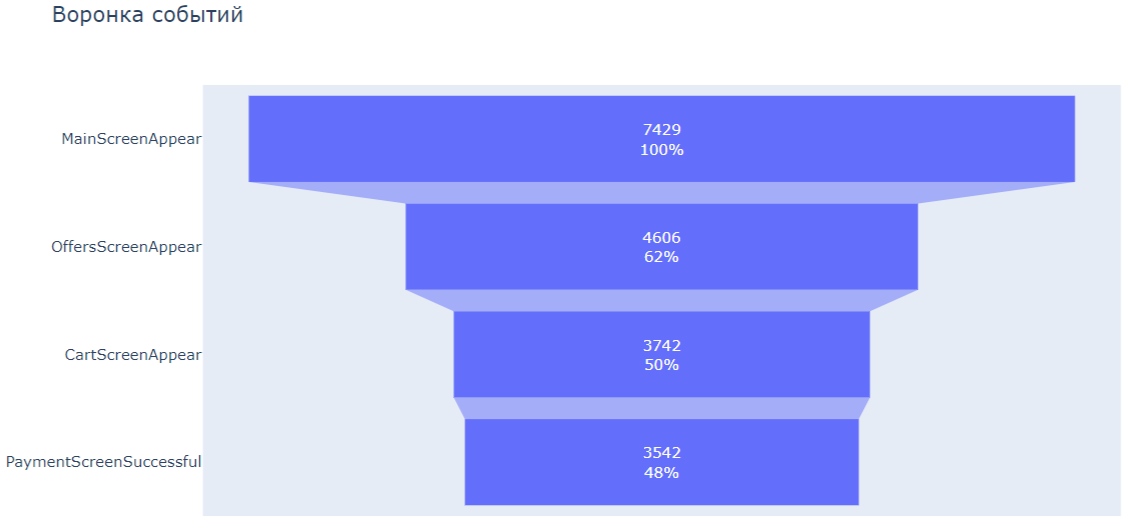

* Целых 38,5% пользователей отвеивается при переходе на следующий уровень воронки.
* 18% потенциальных клиентов теряется на этапе перехода с корзины к покупке.

**Посмотрим на распределение по группам**

In [ ]:
from plotly import graph_objects as go

logs_grouped = (logs_new[logs_new['event_name'] != 'Tutorial']
                .pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique')
               )
logs_grouped = logs_grouped.sort_values(246, ascending=False)

fig = go.Figure()

exp_ids = [246, 247, 248]

for i in range(len(exp_ids)):
    exp_id = exp_ids[i]
    
    fig.add_trace(go.Funnel(
        name=str(exp_id),
        orientation='h',
        y=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'],
        x=logs_grouped[exp_id],
        textposition='inside',
        textinfo='value+percent initial'
    ))

fig.update_layout(
    title_text='Воронка событий, распределенных по группам',  
)
    
fig.show()

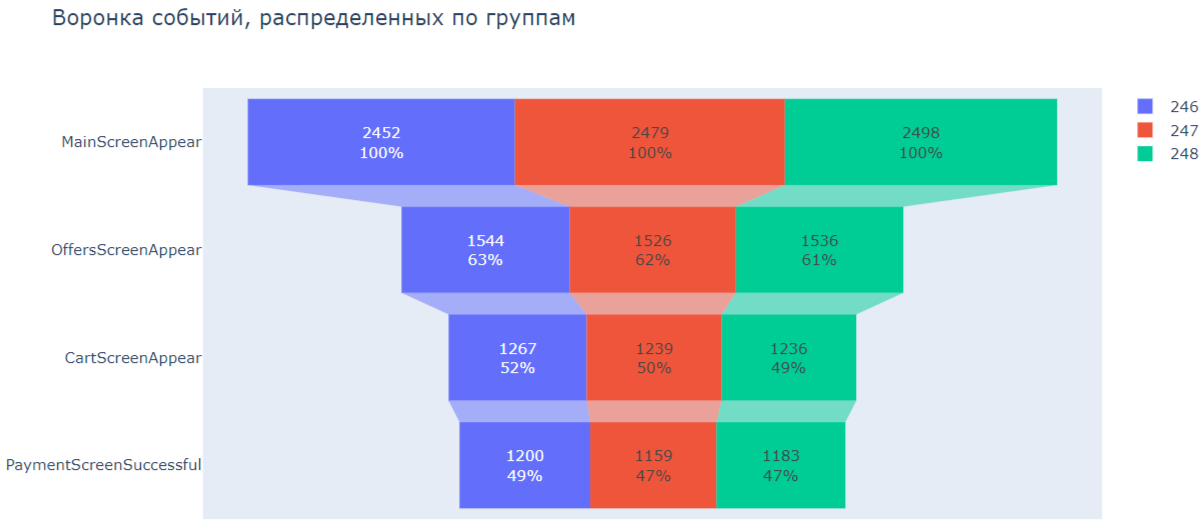

**Промежуточный вывод**

1. Больше всего пользователей отсеивается на этапе `MainScreenOffer`. Причин этому может быть несколько:
    1. возможно лендинг основной страницы неисправно работает 
    2. не продуман ux/ui
    3. возникли другие технические проблемы
2. Около 50% от изначального количества пользователей доходит до покупки товаров.
3.  Смотря на событийные воронки по каждой группе, нельзя сказать, что показатели сильно отличаются.

### Изучение результатов эксперимента

**Посмотрим на количество пользователей в каждой экспериментальной группе**

In [ ]:
logs_filt = logs_new[logs_new['event_name'] != 'Tutorial'].groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()
logs_filt

Примерно одинаковое количество пользователей в группах.

Посмотрим пересекаются ли пользователи из разных групп

In [ ]:
intersection = logs_new.groupby('user_id').agg({'exp_id' : 'nunique'}).reset_index()

if (intersection['exp_id'] > 1).any():
    print('Есть пересечения по пользователям')
else:
    print('Нет пересечений по пользователям')

**Проверка различий контрольных групп**

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [ ]:
round(1 - logs_filt[logs_filt['exp_id'] == 246]['user_id'].iloc[0] / 
      logs_filt[logs_filt['exp_id'] == 247]['user_id'].iloc[0], 2)

Количество пользователей в различных группах различается не более, чем на 1%, что несущественно

**Проверка различий между контрольными группами**

Гипотезы

**Нулевая**: различий между группами нет

**Альтернативная**: различия есть

Уровень значимости примем за 5%

In [ ]:
# составим функцию для проведения теста сравнения пропорций двух генеральных совокупностей по выборкам из них

def group_diff(group1, group2, alpha):

    alpha = alpha  # критический уровень статистической значимости

    for e in logs_grouped.index:

        # пропорция успехов в первой группе:
        p1 = (
            logs_grouped[group1][e]
            / logs_filt[logs_filt['exp_id'] == group1]['user_id'].iloc[0]
        )

        # пропорция успехов во второй группе:
        p2 = (
            logs_grouped[group2][e]
            / logs_filt[logs_filt['exp_id'] == group2]['user_id'].iloc[0]
        )
                
        # пропорция успехов в комбинированном датасете:
        p_combined = (logs_grouped[group1][e] + logs_grouped[group2][e]) / (
            logs_filt[logs_filt['exp_id'] == group1]['user_id'].iloc[0]
            + logs_filt[logs_filt['exp_id'] == group2]['user_id'].iloc[0]
        )

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(
            p_combined
            * (1 - p_combined)
            * (
                1 / logs_filt[logs_filt['exp_id'] == group1]['user_id'].iloc[0]
                + 1 / logs_filt[logs_filt['exp_id'] == group2]['user_id'].iloc[0]
            )
        )

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(f'На событии {e} p-значение: {p_value}')

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница', '\n')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными', '\n'
            )

group_diff(246, 247, 0.05)

Ни на самом популярном (`MainScreenAppear`) этапе событийной воронки, ни на любом другом не было найдено статистически значимых различий между контрольными группами.

Посмотрим есть ли статистически значимые различия между контрольными группами и группой с измененным шрифтом.

**Проверка различий между всеми группами**

In [ ]:
group_diff(246, 248, 0.05)

Результаты теста между 246 (контрольной) и 248 (экспериментальной) не показали значимых статистических различий

In [ ]:
group_diff(247, 248, 0.05)

Результаты теста между 246 (контрольной) и 248 (экспериментальной) также не показали значимых статистических различий

Объединим две контрольные группы и проведем тест с экспериментальной

In [ ]:
# добавляем новый столбец '249', который объединяет 2 контрольные группы
logs_grouped[249] = logs_grouped[246] + logs_grouped[247]
uni_group = logs_filt.loc[0, 'user_id'] + logs_filt.loc[1, 'user_id']
logs_filt.loc[len(logs_filt.index)] = [249, uni_group]

In [ ]:
group_diff(249, 248, 0.05)

Сравнение результатов экспериментальной групы с объединенными контрольными не выявило статистически значимых различий.

**Промежуточный вывод**

1. Для проведения тестов был определен уровень значимости в 5%.
2. При выбранном уровнке значимости не было выявлено различий между контрольными и экспериментальной группами. 
3. Всего было сделано 16 проверок статистических гипотез, т.е. учитывая поправку Бонферрони, уровень значимости можно было бы поставить 0.05/16 = 0.003, или 0.3%

####

### Общий вывод

Исходя из анализа событийной воронки можно сказать, что клиентский путь строится достаточно линейно и стандартно. Его можно описать так:
1. Пользователей заходит на главную страницу
2. Заходит в раздел с товарами
3. Добавляет товар в корзину
4. Оплачивает заказ.

Около 38% пользователей отсеиваются на 1-м уровне, 24% на этапе просмотра товаров, 20% кладут товар в корзину и не покупают, только 18% делают заказ.

При этом почти все пользователи (98%) хотя бы раз переходили на главную страницу, а из 46% доходили до оплаты заказа.

Что касается результатов a/b-теста: его следует прекратить и зафиксировать отсутствие различий между группами, т.к. статистические тесты не показали значимых различий между группами с разными шрифтами.